In [1]:
# Reading documents
import pandas as pd
from glob import glob
import spacy
import numpy as np

import warnings 
warnings.simplefilter('ignore')
 
cases_ = pd.read_csv('cases_metadata.csv')
cases_ = cases_.dropna(axis=0, how='any')
cases_ = cases_.reset_index()
cases_.head()

cases_values = np.random.permutation(cases_.values)

cases_values_dict = {}

for v in cases_values:
    cases_values_dict[v[1]] = [v[5],v[2]] # cases_dict[caseid] = x_republican, case_reversed

N_files = 1000
N_rep = 0
N_dem = 0

fnames = np.random.permutation(glob('cases/*txt'))

nlp = spacy.load('en')

iteration = 1

cases_text = []
cases_text_rep = []
cases_text_dem = []
cases_text_pos = {}

stopwords = spacy.lang.en.stop_words.STOP_WORDS

cases_text_dict = {}

for fname in fnames:
    if iteration > N_files:
        break
    caseid = fname.split('\\')[-1][5:-4] # cut filepath and extension
    year = fname.split('\\')[-1][:4]
    
    # Continue if it misses a field in csv
    if not (caseid in cases_values_dict.keys()):
        continue
        
    # Ensures that there is the same number of republicans and democrats
    if cases_values_dict[caseid][0] == 1:
        if N_rep >= N_files/2:
            continue
        N_rep = N_rep + 1
    else:
        if N_dem >= N_files/2:
            continue
        N_dem = N_dem + 1
    
    cases_text_dict[caseid] = []
    
    if iteration % (N_files//10) == 0:
        print(str(100*iteration/N_files) + "%")
    
    text = open(fname,'r', encoding='utf8').read() # read file as string
    doc=nlp(text)
    for sent in doc.sents:
        sentence = []
        for token in sent:
            # remove spaces, punctuation, stopwords and digits
            if not(token.is_space) and not(token.is_punct) and not('.' in token.lemma_) \
               and not(token.is_stop) and not(token.is_digit): 
                sentence.append(token.lemma_)
                cases_text_pos[token.lemma_] = token.pos_
                cases_text_dict[caseid].append(token.lemma_)
        if len(sentence) == 0:
            continue
        cases_text.append(sentence)
        if cases_values_dict[caseid][0] == 1:
            cases_text_rep.append(sentence)
        else:
            cases_text_dem.append(sentence)
    iteration = iteration + 1


10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


In [92]:
# 1.

import multiprocessing
cores = multiprocessing.cpu_count()

from random import shuffle
shuffle(cases_text)

from gensim.models import Word2Vec

model_w2 = Word2Vec(cases_text, size=100, window=2, min_count=10, workers=cores-1)
model_w2.train(cases_text, total_examples=len(cases_text), epochs=100)

model_w16 = Word2Vec(cases_text, size=100, window=16, min_count=10, workers=cores-1)
model_w16.train(cases_text, total_examples=len(cases_text), epochs=100)

(159802663, 177148000)

In [41]:
# Small window groups words that can replace each other in a sentence
# Large window groups words that belong to same topic

print("Window size 2:")
print(*model_w2.wv.most_similar('freedom'),sep='\n')
print()
print("Window size 16:")
print(*model_w16.wv.most_similar('freedom'),sep='\n')

Window size 2:
('free', 0.5878485441207886)
('right', 0.4509763717651367)
('pea', 0.4255133271217346)
('liberty', 0.41624829173088074)
('political', 0.40326249599456787)
('protect', 0.39968031644821167)
('group', 0.37764328718185425)
('ability', 0.3759889602661133)
('speech', 0.374794065952301)
('self', 0.373055636882782)

Window size 16:
('free', 0.6017396450042725)
('right', 0.48483654856681824)
('expression', 0.47049403190612793)
('religion', 0.4503258466720581)
('religious', 0.42740169167518616)
('curriculum', 0.4084630012512207)
('political', 0.40588802099227905)
('governmental', 0.40122130513191223)
('abridge', 0.39020222425460815)
('guarantee', 0.38511374592781067)


In [34]:
from collections import defaultdict
word_freq = defaultdict(int)
for sent in cases_text:
    for i in sent:
        word_freq[i] += 1

freq_words = sorted(word_freq, key=word_freq.get, reverse=True)[:100]

print(freq_words)

['court', 'the', "'s", '-PRON-', 'state', 'case', 'act', 'district', 'in', 'states', 'law', 'united', 'claim', 'defendant', 'hold', 'federal', 'right', 'section', 'order', 'evidence', 'see', 'issue', 'action', 'find', 'rule', 'statute', 'plaintiff', 'government', 'fact', 'require', 'trial', 'question', 'decision', 'provide', 'congress', 'time', 'commission', 'interest', 'cir', 'board', 'judgment', 'company', 'party', 'supreme', 'appeal', 'judge', 'appellant', 'employee', 'provision', 'tax', 'this', 'deny', 'purpose', 'apply', 'new', 'jury', 'public', 'amendment', 'file', 'union', 'determine', 'power', 'review', 'year', '$', 'consider', 'circuit', 'present', 'jurisdiction', 'Idaho', 'property', 'use', 'regulation', 'grant', 'say', 'conclude', 'result', 'service', 'include', 'general', 'record', 'opinion', 'charge', 'note', 'contract', 'agreement', 'policy', 'motion', 'because', 'give', 'follow', 'reason', 'pay', 'base', 'violation', 'effect', 'as', 'support', 'argue', 'on']


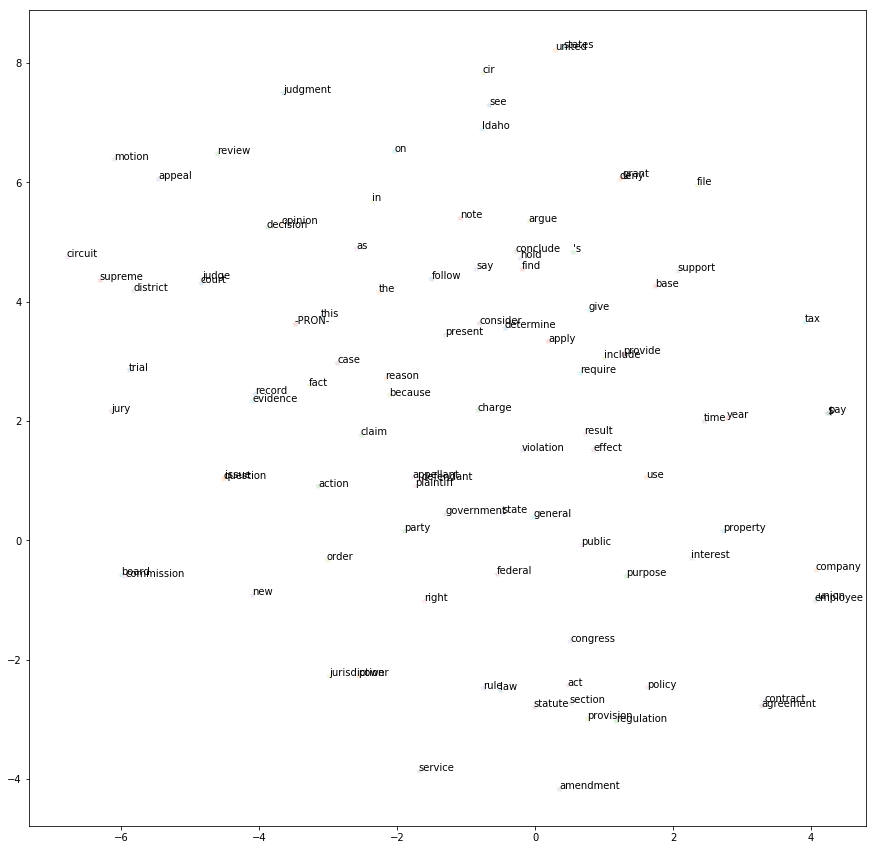

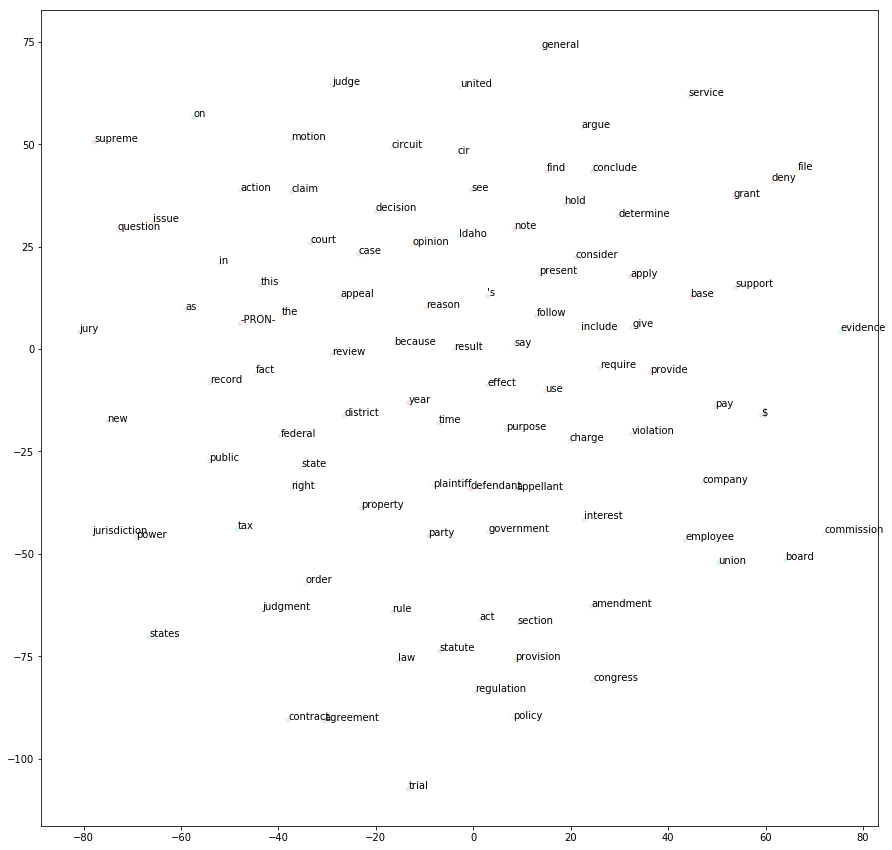

In [39]:
from sklearn.manifold import TSNE # for dimension reduction
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

plot_words2 = np.random.permutation(list(model_w2.wv.vocab.keys()))[:100] 
plot_words2_vec = [model_w2.wv[v] for v in freq_words]
plot_vec2 = TSNE(n_components=2).fit_transform(plot_words2_vec)

for v in range(len(plot_words2)):
    x=plot_vec2[v][0]
    y=plot_vec2[v][1]
    plt.plot(x, y, '*', alpha=0.1)
    plt.text(x, y, freq_words[v], fontsize=10)
plt.show()

plt.figure(figsize=(15,15))

plot_words16 = np.random.permutation(list(model_w16.wv.vocab.keys()))[:100] 
plot_words16_vec = [model_w16.wv[v] for v in freq_words]
plot_vec16 = TSNE(n_components=2).fit_transform(plot_words16_vec)

for v in range(len(plot_words16)):
    x=plot_vec16[v][0]
    y=plot_vec16[v][1]
    plt.plot(x, y, '*', alpha=0.1)
    plt.text(x, y, freq_words[v], fontsize=10)
plt.show()


In [43]:
# 2.

# Large window is used, so we can pick up topics that parties talk about

model_rep = Word2Vec(cases_text_rep, size=100, window=16, min_count=10, workers=cores-1)
model_rep.train(cases_text_rep, total_examples=len(cases_text_rep), epochs=100)             
    
model_dem = Word2Vec(cases_text_dem, size=100, window=16, min_count=10, workers=cores-1)
model_dem.train(cases_text_dem, total_examples=len(cases_text_dem), epochs=100)

(77497977, 87536700)

In [45]:
concept = 'freedom'

concept_adj = []

for v in list(model_w16.wv.vocab.keys()):
    if cases_text_pos[v] == 'ADJ':
        concept_adj.append([model_w16.wv.similarity(concept,v),v])

concept_adj_most = np.array(concept_adj)[np.argsort([v[0] for v in concept_adj])][::-1][:10]
concept_adj_most = [v[1] for v in concept_adj_most]
print(concept_adj_most)

['free', 'religious', 'political', 'governmental', 'academic', 'muslim', 'secular', 'presidential', 'unincorporated', 'oppressive']


In [44]:
concept = 'freedom'

concept_adj = []

for v in list(model_rep.wv.vocab.keys()):
    if cases_text_pos[v] == 'ADJ':
        concept_adj.append([model_rep.wv.similarity(concept,v),v])

concept_adj_most = np.array(concept_adj)[np.argsort([v[0] for v in concept_adj])][::-1][:10]
concept_adj_most = [v[1] for v in concept_adj_most]
print(concept_adj_most)

concept_adj = []

for v in list(model_dem.wv.vocab.keys()):
    if cases_text_pos[v] == 'ADJ':
        concept_adj.append([model_dem.wv.similarity(concept,v),v])

concept_adj_most = np.array(concept_adj)[np.argsort([v[0] for v in concept_adj])][::-1][:10]
concept_adj_most = [v[1] for v in concept_adj_most]
print(concept_adj_most)

# We can see that democrats use word freedom in religious topics (muslim, religious, secular),
# while republicans use it in law/historical topic (constitutional, historic, justified)

['free', 'constitutional', 'political', 'first', 'unincorporated', 'organic', 'oppressive', 'historic', 'governmental', 'justified']
['free', 'muslim', 'religious', 'political', 'associational', 'secular', 'academic', 'expressive', 'characteristic', 'basic']


In [15]:
# 3.
# Hartford et al 2017, Deep Instrumental Variables

from sklearn.cluster import KMeans

Xw = list(model_w2.wv.vocab.keys())
Xv = [model_w2.wv[v] for v in Xw]

N_clusters = 50

kmeans = KMeans(n_clusters=N_clusters, random_state=0).fit(Xv)

for i in range(N_clusters):
    n_elem = 0
    print("---------- Class " + str(i+1) + " ----------")
    for j in range(len(kmeans.labels_)):
        if kmeans.labels_[j] == i:
            n_elem = n_elem + 1
            print(Xw[j])
        if n_elem == 5:
            print()
            break

kmeans_dict = {}
for j in range(len(kmeans.labels_)):
        kmeans_dict[Xw[j]]=kmeans.labels_[j]

---------- Class 1 ----------
inter
publicly
currently
hazardous
---------- Class 2 ----------
interpret
statutory
vi
ix
amendment

---------- Class 3 ----------
narcotic
charge
willfully
possession
drug

---------- Class 4 ----------
february
on
november
after
nearly

---------- Class 5 ----------
jail
patrick
john
collector
vice

---------- Class 6 ----------
bar
deny
seek
disqualify
withhold

---------- Class 7 ----------
oregon
united
states
city
unsettled

---------- Class 8 ----------
personally
check
supervisor
report
attorney

---------- Class 9 ----------
reason
reasonably
useful
longer
factor

---------- Class 10 ----------
rely
cite
's
reject
conclude

---------- Class 11 ----------
oil
bull
roebuck
lumber
petroleum

---------- Class 12 ----------
natural
product
milk
sale
commercial

---------- Class 13 ----------
interrupt
let
intermittent
helfand
long

---------- Class 14 ----------
supra
nom
cir
11th
cal

---------- Class 15 ----------
association
practices
scripps
servs

In [16]:
from collections import Counter

text_features_dict = {}
x_input = []
y_output = []
z_instrument = []
for k,v in cases_text_dict.items():
    word_counts = Counter(v)
    features = np.zeros(N_clusters)
    for w in v:
        if w in kmeans_dict.keys():
            features[kmeans_dict[w]] = word_counts[w]
    text_features_dict[k] = features
    x_input.append(features)
    y_output.append(int(cases_values_dict[k][1]))
    z_instrument.append(int(cases_values_dict[k][0]))

x_input = np.array(x_input)    
y_output = np.array(y_output) 
z_instrument = np.array(z_instrument) 

pd.to_pickle(x_input,'x_input_1000_50.pkl')
pd.to_pickle(y_output,'y_output_1000_50.pkl')
pd.to_pickle(z_instrument,'z_instrument_1000_50.pkl')

In [64]:
x_input = pd.read_pickle('x_input_1000_50.pkl')  
y_output = pd.read_pickle('y_output_1000_50.pkl')  
z_instrument = pd.read_pickle('z_instrument_1000_50.pkl')  

# Scaling with Sparsity
from sklearn.preprocessing import StandardScaler
sparse_scaler = StandardScaler(with_mean=False)
x_input = sparse_scaler.fit_transform(x_input)  

rep_rev = 0
dem_rev = 0
for i in range(len(y_output)):
    if y_output[i] == 1:
        if z_instrument[i] == 1:
            rep_rev = rep_rev + 1
        else:
            dem_rev = dem_rev + 1
print(rep_rev)
print(dem_rev)

rep_rev = 0
dem_rev = 0
for k,v in cases_values_dict.items(): 
    if v[1] == 1:
        if v[0] == 1:
            rep_rev = rep_rev + 1
        else:
            dem_rev = dem_rev + 1
print(rep_rev)
print(dem_rev)

301
310
1326
1403


In [88]:
# Spliting data into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test , z_train, z_test = train_test_split(x_input, y_output, z_instrument, test_size=0.2)


from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2
from keras.layers import Dropout

import keras
import mdn

print("First stage!")

N_HIDDEN = 16  # number of hidden units in the Dense layer
N_MIXES = 10  # number of mixture components
OUTPUT_DIMS = 50  # number of real-values predicted by each mixture component

model_1 = Sequential()
model_1.add(Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model_1.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model_1.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer='adam')
         
model_1.fit(z_train, x_train, epochs=10, batch_size=16, validation_data=(z_test, x_test), verbose=2)
model_1.summary()

xp_input = model_1.predict(z_instrument)
xp_train = model_1.predict(z_train)
xp_test = model_1.predict(z_test)

print("Second stage!")

model_2 = Sequential()
model_2.add(Dense(units=64, activation='relu'))
model_2.add(Dense(units=32, activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
          
model_2.fit(xp_train, y_train, epochs=10, batch_size=16, validation_data=(xp_test, y_test), verbose=2)
model_2.summary()

yp_output = model_2.predict(xp_input)
yp_train = model_2.predict(xp_train)
yp_test = model_2.predict(xp_test)


First stage!
Train on 800 samples, validate on 200 samples
Epoch 1/10
 - 10s - loss: 77.2465 - val_loss: 69.0188
Epoch 2/10
 - 0s - loss: 70.3138 - val_loss: 62.0413
Epoch 3/10
 - 0s - loss: 62.5008 - val_loss: 56.5335
Epoch 4/10
 - 0s - loss: 56.9900 - val_loss: 53.4380
Epoch 5/10
 - 0s - loss: 53.6586 - val_loss: 51.5384
Epoch 6/10
 - 0s - loss: 51.4354 - val_loss: 50.3334
Epoch 7/10
 - 0s - loss: 49.7942 - val_loss: 49.3544
Epoch 8/10
 - 0s - loss: 48.5618 - val_loss: 48.5514
Epoch 9/10
 - 0s - loss: 47.5236 - val_loss: 47.9539
Epoch 10/10
 - 0s - loss: 46.7062 - val_loss: 47.3237
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 16)                32        
_________________________________________________________________
mdn_14 (MDN)                 (None, 1010)              17170     
Total params: 17,202
Trainable params: 17,202
Non-trainable params: 0
_________

In [55]:
xp_input = model_1.predict(z_instrument)
xp_train = model_1.predict(z_train)
xp_test = model_1.predict(z_test)

yp_output = model_2.predict(xp_input)
yp_train = model_2.predict(xp_train)
yp_test = model_2.predict(xp_test)

In [91]:
tp = 0
yp_mean = np.mean(yp_train)
for i in range(len(yp_train)):
    if yp_train[i] > yp_mean:
        yp_train[i] = 1
    else:
        yp_train[i] = 0
    if yp_train[i] == y_train[i]:
        tp = tp + 1
print("Accuracy train ",tp/N_files/0.8)

tp = 0
yp_mean = np.mean(yp_test)
for i in range(len(yp_test)):
    if yp_test[i] > yp_mean:
        yp_test[i] = 1
    else:
        yp_test[i] = 0
    if yp_test[i] == y_test[i]:
        tp = tp + 1
print("Accuracy test  ",tp/N_files/0.2)

tp = 0
yp_mean = np.mean(yp_output)
for i in range(len(yp_output)):
    if yp_output[i] > yp_mean:
        yp_output[i] = 1
    else:
        yp_output[i] = 0
    if yp_output[i] == y_output[i]:
        tp = tp + 1
print("Accuracy all   ",tp/N_files)

Accuracy train  0.5199999999999999
Accuracy test   0.46499999999999997
Accuracy all    0.509
